In [1]:
import numpy as np

from scipy import signal, fft

import matplotlib.pyplot as plt

In [69]:
def plot_response(w, h, title):
    "Utility function to plot response functions"
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(w, 20*np.log10(np.abs(h)))
    ax.set_ylim(-60, 5)
    ax.grid(True)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Gain (dB)')
    ax.set_title(title)

In [3]:
def fold(x, gain):
    x = x * gain
    ft = np.floor((x+1)*0.5)
    sign = np.zeros(ft.size)
    for n in range(sign.size):
        if(sign[n]%2 == 0):
            sign[n] = 1
        else:
            sign[n] = -1
    
    ret = sign*(x-2*ft)
    return ret

In [4]:
def distort(x, gain):
    x = np.tanh(x*gain) / np.tanh(gain);
    return x

In [5]:
def get_dft(x, fs):
    dft = 2*fft.fft(x)/(x.size)
    dft_freq = fft.fftfreq(x.size, d=1/fs)

    return dft, dft_freq

In [6]:
def before_and_after(x, y, fs):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    xdft, xdft_freq = get_dft(x, fs)
    ax.plot(xdft_freq, 20*np.log10(np.abs(xdft)))
    ydft, ydft_freq = get_dft(y, fs)
    ax.plot(ydft_freq, 20*np.log10(np.abs(ydft)))
    ax.set_ylim(-60, 10)

In [7]:
def plot_dft(x, fs):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    xdft, xdft_freq = get_dft(x, fs)
    ax.plot(xdft_freq, 20*np.log10(np.abs(xdft)))
    ax.set_ylim(-60, 10)

In [102]:
def get_halfband(ntaps, gain=2):
    t_band = 0.1
    taps = signal.remez(ntaps, [0, 0.25-(t_band/2), 0.25+(t_band/2), 0.5], [gain, 0])
    for n in range(taps.size):
        if abs(taps[n]) < 0.0001:
            taps[n] = 0
    return taps

In [9]:
def upsample(x, factor):
    n = x.size
    ret = np.zeros((factor*n))
    ret[::factor] = x
    return ret

In [55]:
class ringBuffer:
    def __init__(self, ntaps):
        self.ntaps = ntaps
        self.buffer = np.zeros(ntaps)
        self.pos = 0
        
    def add(self, sample):
        self.buffer[self.pos] = sample
        self.pos = self.pos + 1
        if self.pos == self.ntaps:
            self.pos = 0
    
    def read(self, index):
        assert index < self.ntaps
        index = self.pos - index - 1
        if index < 0:
            index = index + self.ntaps
        
        return self.buffer[index]

In [95]:
class halfBand:
    def __init__(self, taps):
        self.ntaps = taps.size
        self.taps = taps
        self.buf = ringBuffer(self.ntaps)
        
    def process_23(self, sample):
        ret = 0
        self.buf.add(sample)
        ret = (self.buf.read(0)+self.buf.read(22)) * self.taps[0]
        ret = ret + (self.buf.read(2)+ self.buf.read(20)) * self.taps[2]
        ret = ret + (self.buf.read(4)+ self.buf.read(18)) * self.taps[4]
        ret = ret + (self.buf.read(6)+ self.buf.read(16)) * self.taps[6]
        ret = ret + (self.buf.read(8)+ self.buf.read(14)) * self.taps[8]
        ret = ret + (self.buf.read(10)+ self.buf.read(12)) * self.taps[10]
        ret = ret + self.buf.read(11) * self.taps[11]

        return ret
        

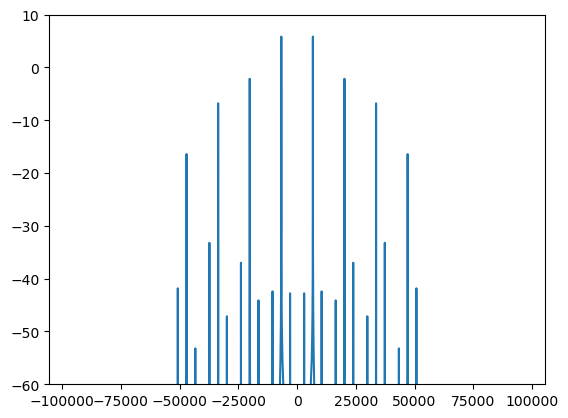

In [147]:
oversample = 2
fs = 96000
t = np.linspace(0, 1, fs)
f = 6724
x = np.sin(2*np.pi*f*t)
tanh_gain = 10
fold_gain = 1

xu = upsample(x, oversample)
taps = get_halfband(23, gain = 2)
xuf = signal.convolve(xu, taps)
xuu = upsample(xuf, oversample)
xuuf = signal.convolve(xuu, taps)

#filt = halfBand(taps)
#xtest = np.zeros(xu.size)
#for n in range(xu.size):
#    xtest[n] = filt.process_23(xu[n])

xf = fold(xu, fold_gain)
xff = signal.convolve(xf, taps)

xd = distort(xuf, tanh_gain)
xdf = signal.convolve(xd, taps)

plot_dft(xdf, fs*oversample)

plt.show()

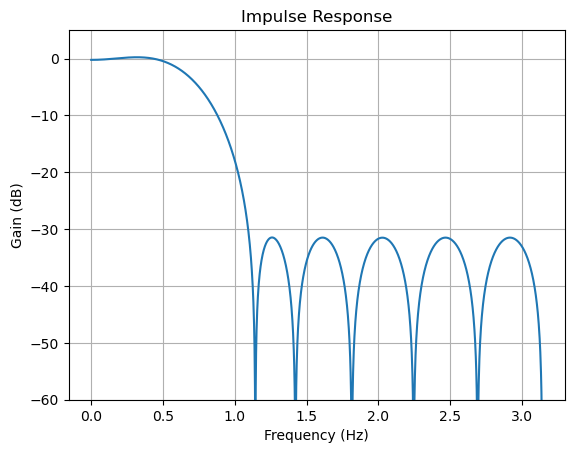

In [70]:
t_band = 0.1
cutoff = 0.125
ntaps = 14
taps = signal.remez(ntaps, [0, cutoff-(t_band/2), cutoff+(t_band/2), 0.5], [1, 0])

w, h = signal.freqz(taps, worN = 2000);    
plot_response(w, h, "Impulse Response")


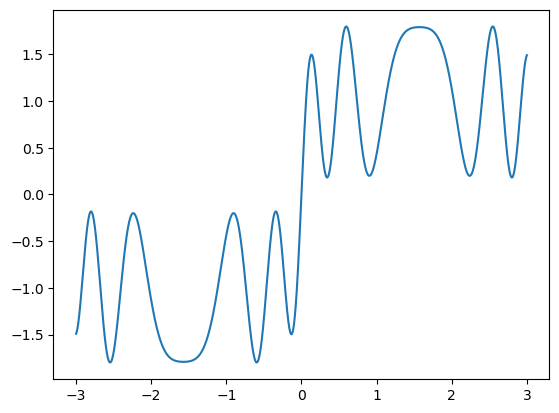

In [65]:
fs = 1000
span = 3
gain = 7


t = np.linspace(-span, span, 2*span*fs)
x = np.sin(t)
f = np.tanh(x*gain) / np.tanh(gain) + 0.8*np.sin(2*x*gain)
y = np.sin(np.pi/2*t)


plt.plot(t, f)
#plt.plot(t, t)
#plt.plot(t, y)

In [22]:
10**0-1

0